In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.neighbors import LocalOutlierFactor

import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import LocalOutlierFactor


pd.set_option('display.max_colwidth', 355)
pd.set_option('display.max_rows', 100)

In [2]:
df = pd.read_csv('datasets/b3_stocks_1994_2020.csv')
#df = pd.read_csv('../b3data/b3_stocks_1994_2020.csv')

## IBOV Ações - Exploração inicial

In [3]:
df.head()

,datetime,ticker,open,close,high,low,volume
0,1994-07-04,ACE 3,48.00,48.00,48.00,47.00,46550.0
1,1994-07-04,ALP 3,155.27,156.00,156.00,155.27,163405.8
2,1994-07-04,ALP 4,131.00,131.00,131.00,131.00,6550.0
3,1994-07-04,IBP 6,600.00,600.00,600.00,600.00,7800.0
4,1994-07-04,AQT 4,0.89,0.99,0.99,0.85,13137.0


In [4]:
df.shape

(1883203, 7)

## Tratamento dos dados

In [5]:
# Convertendo string para datetime
df['datetime'] = pd.to_datetime(df['datetime'])

In [6]:
# Removendo coluna não utilizada
df = df.drop(['volume'], axis=1)

### Criação de novas features

In [7]:
# Variação diária em porcentagem 
df['delta_open'] = df.apply(lambda x: (abs(x['open'] - x['close']) / x['open']), axis=1)

In [8]:
# Indica se a variação foi positiva, negativa ou zero
def calc_delta_side(row):
    delta = row['open'] - row['close']
    if delta > 0:
        return 1
    elif delta == 0:
        return 0
    else:
        return -1

df['delta_side'] = df.apply(lambda row: calc_delta_side(row), axis=1)

**Coluna delta_high faz sentido??? (high - low)**

### Removendo dados que não fazem sentido
com por exemplo, preço máximo menor do que o preço de abertura

In [9]:
# Muita low e high com muita variação mas close e open próximos
df.loc[df['delta_open'] > 10].head(10)

,datetime,ticker,open,close,high,low,delta_open,delta_side
122258,1996-08-14,LAE 4,0.05,0.59,0.59,0.05,10.800000,-1
582487,2005-03-18,TPEC11B,1.00,33.00,1.00,1.00,32.000000,-1
587314,2005-04-20,ENMA3B,0.39,20.00,0.39,0.39,50.282051,-1
786027,2008-03-13,AMCE3,0.22,3.26,3.26,0.22,13.818182,-1


#### Seriam esses dois dados ruido? (high = 1 / close = 33)

In [11]:
df = df.loc[(df['high'] >= df['open']) & (df['high'] >= df['close'])]
df = df.loc[(df['open'] >= df['low']) & (df['close'] >= df['low'])]

df = df.loc[(df['high'] >= df['low'])]

df.shape

(1882841, 8)

### Plotando distribuições

In [24]:
df.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,open,close,high,low,delta_open,delta_side
count,1882841.00000,1882841.00000,1882841.00000,1882841.00000,1882841.00000,1882841.00000
mean,68.07674,68.21162,68.75885,67.47485,0.01951,0.01085
std,1689.92439,1695.21409,1700.11106,1683.74740,0.04342,0.85763
min,0.01000,0.01000,0.01000,0.01000,0.00000,-1.00000
25%,3.96000,3.96000,4.00000,3.89000,0.00000,-1.00000
50%,13.69000,13.70000,13.91000,13.45000,0.00957,0.00000
75%,36.67000,36.70000,37.10000,36.05000,0.02459,1.00000
max,1297776.47000,1297776.47000,1297776.47000,1297776.47000,13.81818,1.00000


<AxesSubplot:xlabel='delta_open'>

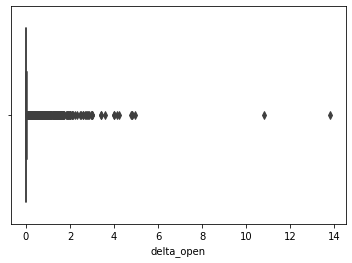

In [12]:
sns.boxplot(x=df['delta_open'])
# Esses pontos são possíveis outliers???

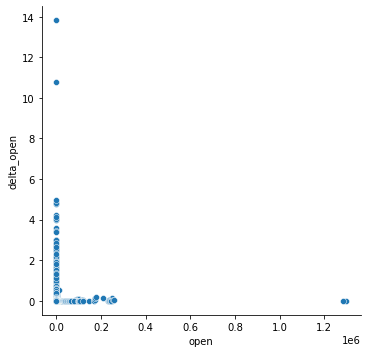

In [13]:
# Cortando uma parte dos dados para ver o gráfico com "zoom"
sns.relplot(x="open", y="delta_open", data=df)

### Normalizando valores

**Normalizar antes ou depois de criar as feature?**

In [14]:
# Normalizando os valores com MinMaxScaler
# df[['open', 'close', 'low', 'high', 'delta_open']] = MinMaxScaler().fit_transform(df[['open', 'close', 'low', 'high', 'delta_open']])

In [15]:
# Normalizando os valores usando normalização logaritmica
# df[['open', 'close', 'low', 'high', 'delta_open']] = np.log(df[['open', 'close', 'low', 'high', 'delta_open']])

### Cortando uma parte dos dados para ver o gráfico com "zoom"

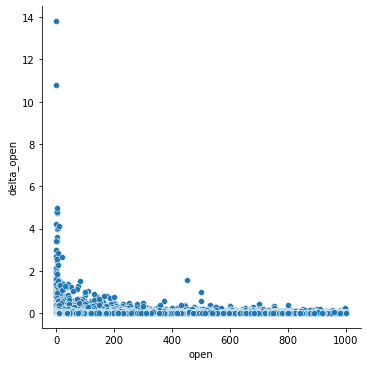

In [23]:
sns.relplot(x="open", y="delta_open", data=df.loc[(df['delta_open'] < 1000) & (df['open'] < 1000)])

## Usaremos dados depois de 95 por causa do plano real
Não temos a informação de como foi realizada a conversão da moeda e o ano de 94 possui muitas observações destoantes

In [ ]:
df = df.loc[df['datetime'] > '1995-01-01']

## Vamos usar apenas dados desse seculo
Ao procurar muitas das ações listadas no dataset não encontramos informações

In [ ]:
df = df.loc[df['datetime'] > '2000-01-01']

#### Entendendo ações da amazon caindo bruscamente

<AxesSubplot:xlabel='datetime', ylabel='close'>

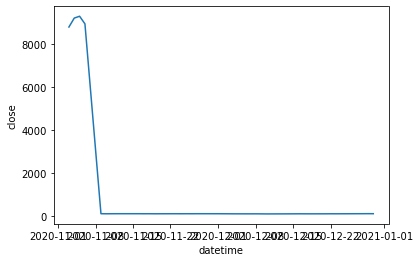

In [17]:
sns.lineplot(x='datetime', y='close', data=df.loc[(df['ticker'] == 'AMZO34') & (df['datetime'] > '2020-11-01') & (df['datetime'] > '2020-11-01')])

In [18]:
# Analisando alguns dados para entender o motivo da variação brusca
df.loc[(df['ticker'] == 'AMZO34') & (df['datetime'] > '2020-11-01') & (df['datetime'] > '2020-11-01')]

,datetime,ticker,open,close,high,low,delta_open,delta_side
1854244,2020-11-03,AMZO34,8638.99,8779.45,8840.00,8444.44,0.016259,-1
1854245,2020-11-04,AMZO34,8951.00,9194.65,9194.65,8951.00,0.027220,-1
1854246,2020-11-05,AMZO34,9207.00,9280.00,9350.00,9164.90,0.007929,-1
1854247,2020-11-06,AMZO34,9280.00,8926.50,9280.00,8870.00,0.038093,1
1854248,2020-11-09,AMZO34,113.71,108.81,117.95,105.96,0.043092,1
1854249,2020-11-10,AMZO34,106.08,105.47,107.27,103.30,0.005750,1
1859273,2020-11-11,AMZO34,106.29,107.55,108.05,104.85,0.011854,-1
1859274,2020-11-12,AMZO34,107.92,108.60,109.61,107.15,0.006301,-1
1859275,2020-11-13,AMZO34,108.66,108.88,110.11,107.78,0.002025,-1
1859276,2020-11-16,AMZO34,107.32,108.88,109.06,106.02,0.014536,-1


#### Provavelmente reindexação (1 ação virou 10 com 1/10 do preço)

### LOF

In [19]:
def get_LOF_scores(df, n_neighbors=10, contamination=0.05):
    np.random.seed(42)

    # fit the model for outlier detection (default)
    clf = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination)
    # use fit_predict to compute the predicted labels of the training samples
    # (when LOF is used for outlier detection, the estimator has no predict,
    # decision_function and score_samples methods).
    y_pred = clf.fit_predict(df)

    X_scores = clf.negative_outlier_factor_
    
    df['LOF_score'] = X_scores
    df['LOF_predictions'] = y_pred
    
    return df

In [20]:
def show_2D_outliers(df, x, y, scores, title = ''):

    normalized = (df[scores].max() - df[scores]) / (df[scores].max() - df[scores].min())
    
    t = "Outlier Scores"
    if title: t=t+": "+title
    
    fig, ax = plt.subplots(figsize=(8, 6))

    plt.title(t)
    plt.scatter(x=x, y=y, color='k', s=3., label='Data points', data=df)
    # plot circles with radius proportional to the outlier scores

    plt.scatter(x=x, y=y, s=1000 * normalized, edgecolors='r',
                facecolors='none', label='Outlier scores', data=df)
    plt.axis('tight')
    # plt.xlim((-5, 5))
    # plt.ylim((-5, 5))
    # plt.xlabel("prediction errors: %d" % (n_errors))
    legend = plt.legend(loc='upper left')
    legend.legendHandles[0]._sizes = [10]
    legend.legendHandles[1]._sizes = [20]
    plt.show()

### Aplicando o algoritmo para uma faixa muito densa do dataset

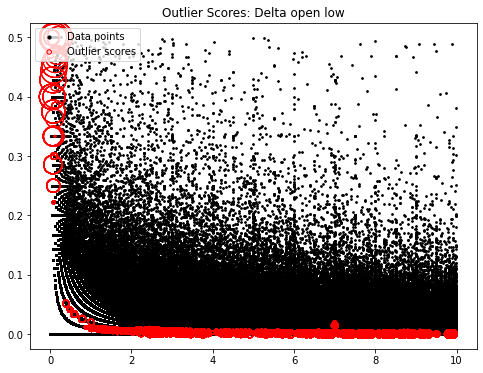

In [21]:
df_low = df[['open', 'delta_open']]
df_low = df_low.loc[(df_low['open'] < 10) & (df_low['delta_open'] < 0.5)]
scores_low = get_LOF_scores(df_low, n_neighbors=300, contamination=0.5)

show_2D_outliers(scores_low, x = 'open', y = 'delta_open', scores = 'LOF_score', title = 'Delta open low')

#### Acreditamos que nesse caso a visualização seja ruim pois alguns circulos ficam grandes o suficiente para ficar fora do gráfico

### Aplicando o algoritmo para uma faixa pouco densa do dataset

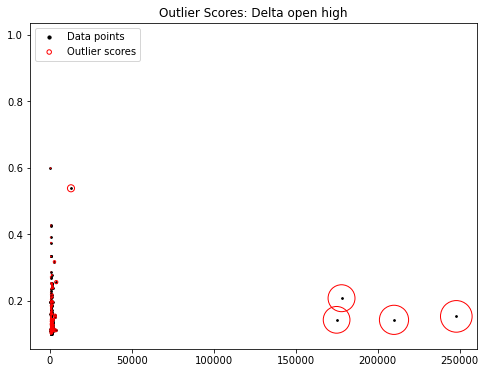

In [22]:
df_high = df[['open', 'delta_open']]
df_high = df_high.loc[(df_high['open'] > 500) & (df_high['delta_open'] > 0.1)]
scores_high = get_LOF_scores(df_high, n_neighbors=100, contamination=0.3)

show_2D_outliers(scores_high, x = 'open', y = 'delta_open', scores = 'LOF_score', title = 'Delta open high')

#### Acreditamos que nesse caso a visualização seja mais efetiva, porém não sabemos como realizar transformações no dataset para chegar numa visualização coerente

## Resultados

#### - Maior problema identificado: disparidade no preço das ações (algumas centavos outras milhares de reais). Como tratar? - Normalização utilizando escala logaritmica???

#### - Sem resultados satisfatórios
#### - Visualização não é boa nesse caso
#### - Quais outras transformações podem ser feitas ou visualizações exploradas?
#### - Como tratar a disparidade entre os preços das ações?

## Opções e próximos passos:

#### - Criação de novas features (temos idéias mas são caras computacionalmente)
#### - Achar outra visualização mais compatível com o problema
#### - Utilizar faixas de tempo diferentes para condensar os dados?
#### - Cortar o dataset?